# Sliding Window And GAN for Explainability (SWAGE)

In [23]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
import math

In [24]:
%matplotlib inline

## Change code below to incorporate your *model* and *input processing*

### Define your model here:

In [25]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

In [26]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

### Load and preprocess image

In [27]:
from keras.preprocessing import image

In [28]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [29]:
image.load_img

<function keras_preprocessing.image.utils.load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest')>

---

## SWAGE + RISE (for comparison)

In [30]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    
    return masks

In [76]:
batch_size = 100

def predict(model, inp, masks, N):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    
    return preds

def relevant_regions(preds, c):
    
    R = np.where(np.argmax(preds, axis=1) == c)
    not_R = np.where(np.argmax(preds, axis=1) != c)
    print(R)
    return R, not_R

def calculate_saliency( preds, masks, N):
    
#     print(masks.shape)
#     print(preds.shape)
#     print(*model.input_size)
#     print(N, -1)////////////
#     print(masks.reshape(N, -1).shape)
#     print(preds.T.dot(masks.reshape(N, -1)).shape)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    
#     print(sal.shape, N, p1)
    sal = sal / N / p1
#     print('sal shape', sal.shape)
    return sal

In [32]:
def explain(model, inp, c):
    
    inp = inp[0]
    # levels
    N = math.floor(inp.shape[0]/10)
    w = math.floor(inp.shape[0]/2)
    S = np.ones((1000, inp.shape[0], inp.shape[1]))
#     print('initial S:', S.shape)
#     print('levels',N)
    R = np.asarray([[0, inp.shape[1], 0, inp.shape[0]]])
    
    for i in range(0, N):
        print('level:',i)
        tmp = []
        print('R shape:', R.shape)
        for r in range(0, R.shape[0]):
            print('Region', R[r])
            n, masks, R_coords = sliding_mask(inp, R[r])
            preds = predict(model, inp, masks, n)
            rel, not_rel = relevant_regions(preds, c)
            
            
            if len(rel[0]) > 0:
                print('relevant regions', rel)
                sal = calculate_saliency(preds[rel], masks[rel], len(rel[0]))
#                 print(sal.shape)
                S = np.add(S, sal)
    #             print('S:',S.shape)
    #             print('saliency map overlapped with the input')
#                 print('R-coords', R_coords, rel[0].tolist())
                tmp.append(R_coords[rel[0].tolist(),:])
        if len(tmp) > 0:
            R = np.concatenate(tmp, axis=0)
            R = np.unique(R, axis=0)
            print(tmp)
#             R = tmp[0]
        else: break
        print('New region coordinates for level {}:{}'.format(i+1,R))
        
    return S 
        

In [ ]:
def sliding_mask(inp, r):
#     print('splitting regions to generate masks')
#     inp = inp[0]
    w = abs(math.floor((r[0] - r[1])/2))
#     print('size of image', w)
    masked = []
    stepSize = math.floor(w/2)
#     stepSize=w
    (w_width, w_height) = (w, w) # window size
    R = []
    for x in range(r[0], r[1] - int(w_width/4) , stepSize):
        for y in range(r[2], r[3] - int(w_height/4), stepSize):
            mask = np.zeros((inp.shape[0], inp.shape[1]))
            coords = [x, x + w_width, y, y + w_height]
            mask[x:x + w_width, y:y + w_height] = 1
#             mask = generate_mask(inp, coords)
#             print(masked.shape)
            plt.figure()
            plt.imshow(mask)
            plt.show()
            masked.append(mask)
            R.append([x, x+w_width, y, y+w_height])
    
    masked = np.array(masked)
    print(masked.shape)
    masks = masked.reshape(-1, *model.input_size, 1)
#     print(masks.shape)
    return masks.shape[0], masks, np.asarray(R)

In [80]:
def generate_mask( inp, coords):
    n = abs(coords[1]-coords[0])
#     print('number of elements:',n)
#     print(coords[0], coords[1], coords[2], coords[3])
#     x = np.ranfom.randint(coords[0], coords[1], n)
#     y = np.ranfom.randint(coords[2], coords[3], n)
    x_mean = np.mean([coords[0],coords[1]])
    x_var = np.var([coords[0], coords[1]])
    y_mean = np.mean([coords[2],coords[3]])
    y_var = np.var([coords[2], coords[3]])
    
    x = np.random.normal(x_mean,x_var,n)  
    y = np.random.normal(y_mean,y_var,n)  
    z = ((x-x_mean)**2+(y-y_mean)**2)
    
#     print(np.min(x),np.max(x))
#     z = x**2+y**2
    # z = [1]*len(x)
    ti = np.linspace(0, inp.shape[0], inp.shape[0])
    XI, YI = np.meshgrid(ti, ti)


    # use RBF
    rbf = Rbf(x, y, z, epsilon=2)
    ZI = rbf(XI, YI)
#     plt.figure()
#     plt.imshow(1-ZI)
#     plt.show()
    return (1-ZI)
        
    

[[0.  0.1 0.2 ... 7.8 7.9 8. ]
 [0.  0.1 0.2 ... 7.8 7.9 8. ]
 [0.  0.1 0.2 ... 7.8 7.9 8. ]
 ...
 [0.  0.1 0.2 ... 7.8 7.9 8. ]
 [0.  0.1 0.2 ... 7.8 7.9 8. ]
 [0.  0.1 0.2 ... 7.8 7.9 8. ]]
(81, 81)


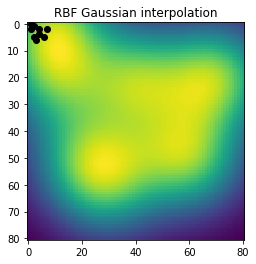

In [35]:
from scipy.interpolate.rbf import Rbf  # radial basis functions
import matplotlib.pyplot as plt
import numpy as np

x = [1, 1, 2 ,3, 4, 4, 2, 6, 7]
y = [0, 2, 5, 6, 2, 4, 1, 5, 2]
z = [1]*len(x)

rbf_adj = Rbf(x, y, z, function='gaussian')

x_fine = np.linspace(0, 8, 81)
y_fine = np.linspace(0, 8, 81)

x_grid, y_grid = np.meshgrid(x_fine, y_fine)
print(x_grid)
z_grid = rbf_adj(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)
print(z_grid.shape)
plt.imshow(z_grid)
# plt.pcolor(x_fine, y_fine, z_grid);
plt.plot(x, y, 'ok');
# plt.xlabel('x'); plt.ylabel('y'); plt.colorbar();
plt.title('RBF Gaussian interpolation');
plt.show()

-87.41599083732854 187.6371832422508


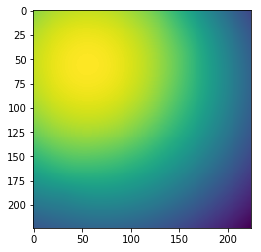

In [54]:
import numpy as np
from scipy.interpolate import Rbf

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import cm

# 2-d tests - setup scattered data
# x = np.random.randint(112, 224, 112)+50
x = np.random.normal(56,56,112)  
y = np.random.normal(56,56,112)  

# y = np.random.randint(0, 112, 112)+56

# x = np.random.rand(5)*20 + 70
# y = np.random.rand(5)*20 + 70
print(np.min(x),np.max(x))
z = ((x-56)**2+(y-56)**2)
# z = [1]*len(x)
ti = np.linspace(0, 224, 224)
XI, YI = np.meshgrid(ti, ti)


# use RBF
rbf = Rbf(x, y, z, epsilon=2)
ZI = rbf(XI, YI)
plt.imshow(1-ZI)
# plot the result
# n = plt.normalize(-2., 2.)
# plt.subplot(1, 1, 1)
# plt.pcolor(XI, YI, 1-ZI, cmap=cm.jet)
# plt.scatter(x, y, 100, z, cmap=cm.jet)
# plt.title('RBF interpolation - multiquadrics')
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
# plt.colorbar()


In [18]:
plt.show()

## Running explanations

In [57]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [58]:
model = Model()

Instructions for updating:
Colocations handled automatically by placer.


In [68]:
img, x = load_img('broccoli1.png')

In [66]:
N_rise = 2000
s = 8
p1 = 0.5
masks_rise = generate_masks(2000, 8, 0.5)

Generating masks: 100%|██████████| 2000/2000 [00:05<00:00, 340.00it/s]


In [77]:
s = 8
p1 = 0.5
N_swage, masks_swage = sliding_mask(x)

TypeError: sliding_mask() missing 1 required positional argument: 'r'

level: 0
R shape: (1, 4)
Region [  0 224   0 224]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


(array([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 13, 14]),)
relevant regions (array([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 13, 14]),)
[array([[  0, 112,   0, 112],
       [  0, 112,  56, 168],
       [  0, 112, 112, 224],
       [ 56, 168,   0, 112],
       [ 56, 168,  56, 168],
       [ 56, 168, 112, 224],
       [112, 224,   0, 112],
       [112, 224,  56, 168],
       [112, 224, 112, 224],
       [168, 280,  56, 168],
       [168, 280, 112, 224]])]
New region coordinates for level 1:[[  0 112   0 112]
 [  0 112  56 168]
 [  0 112 112 224]
 [ 56 168   0 112]
 [ 56 168  56 168]
 [ 56 168 112 224]
 [112 224   0 112]
 [112 224  56 168]
 [112 224 112 224]
 [168 280  56 168]
 [168 280 112 224]]
level: 1
R shape: (11, 4)
Region [  0 112   0 112]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


(array([ 1,  5,  6, 10]),)
relevant regions (array([ 1,  5,  6, 10]),)
Region [  0 112  56 168]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


(array([4, 8]),)
relevant regions (array([4, 8]),)
Region [  0 112 112 224]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


(array([], dtype=int64),)
Region [ 56 168   0 112]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


(array([2]),)
relevant regions (array([2]),)
Region [ 56 168  56 168]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


(array([0]),)
relevant regions (array([0]),)
Region [ 56 168 112 224]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


(array([], dtype=int64),)
Region [112 224   0 112]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


(array([10]),)
relevant regions (array([10]),)
Region [112 224  56 168]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


(array([ 8, 11]),)
relevant regions (array([ 8, 11]),)
Region [112 224 112 224]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


(array([9]),)
relevant regions (array([9]),)
Region [168 280  56 168]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


(array([0, 3]),)
relevant regions (array([0, 3]),)
Region [168 280 112 224]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


(array([1]),)
relevant regions (array([1]),)
[array([[  0,  56,  28,  84],
       [ 28,  84,  28,  84],
       [ 28,  84,  56, 112],
       [ 56, 112,  56, 112]]), array([[ 28,  84,  56, 112],
       [ 56, 112,  56, 112]]), array([[ 56, 112,  56, 112]]), array([[ 56, 112,  56, 112]]), array([[168, 224,  56, 112]]), array([[168, 224,  56, 112],
       [168, 224, 140, 196]]), array([[168, 224, 140, 196]]), array([[168, 224,  56, 112],
       [168, 224, 140, 196]]), array([[168, 224, 140, 196]])]
New region coordinates for level 2:[[  0  56  28  84]
 [ 28  84  28  84]
 [ 28  84  56 112]
 [ 56 112  56 112]
 [168 224  56 112]
 [168 224 140 196]]
level: 2
R shape: (6, 4)
Region [ 0 56 28 84]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


(array([], dtype=int64),)
Region [28 84 28 84]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


(array([], dtype=int64),)
Region [ 28  84  56 112]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


(array([], dtype=int64),)
Region [ 56 112  56 112]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


(array([], dtype=int64),)
Region [168 224  56 112]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


(array([], dtype=int64),)
Region [168 224 140 196]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 224, 224)


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

(array([], dtype=int64),)


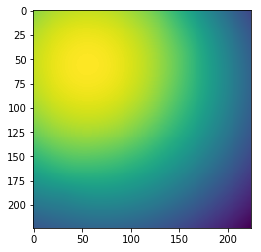

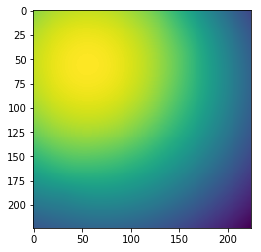

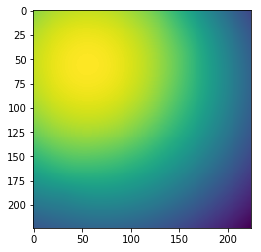

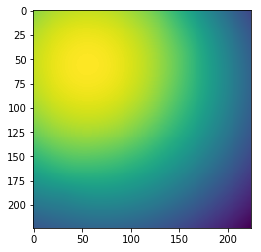

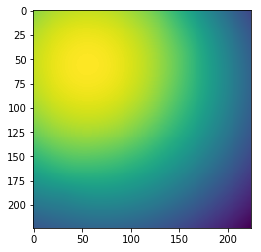

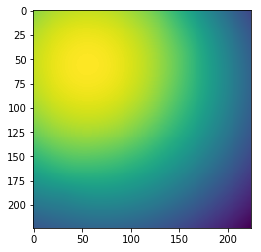

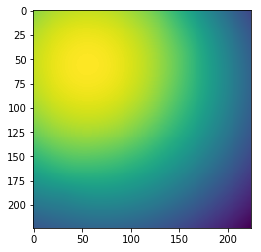

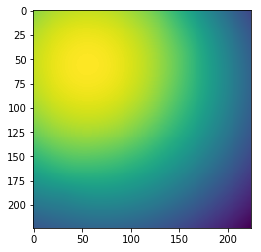

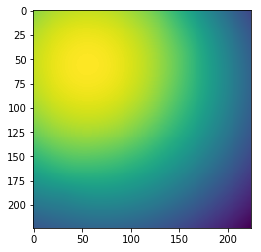

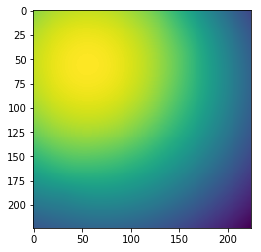

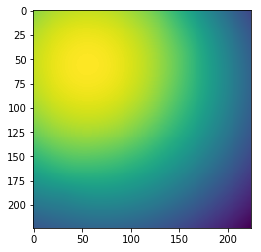

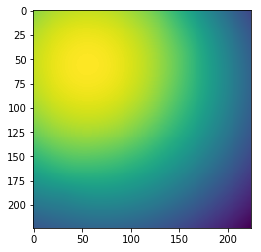

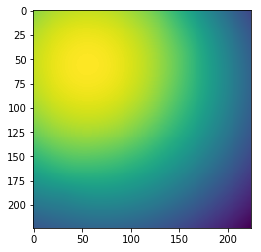

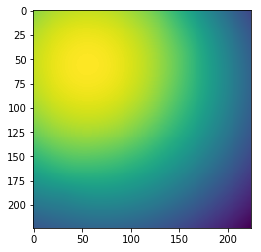

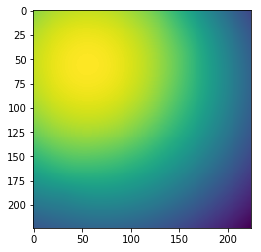

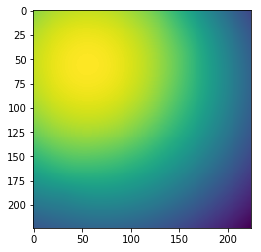

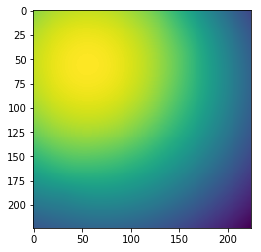

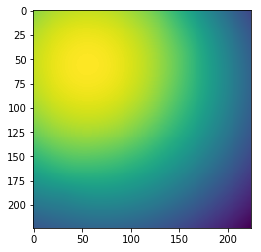

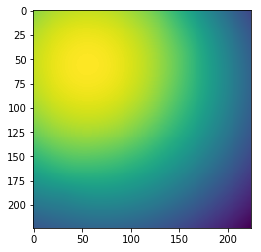

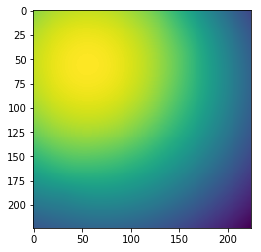

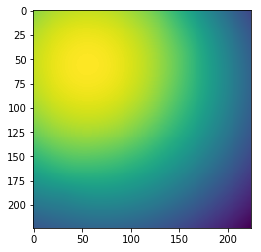

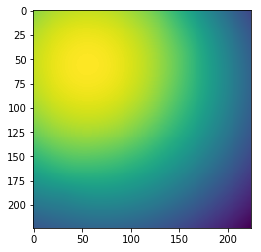

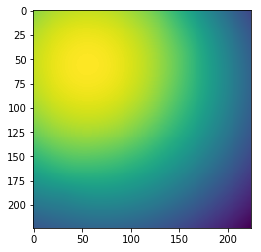

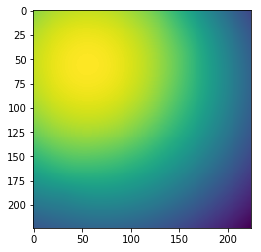

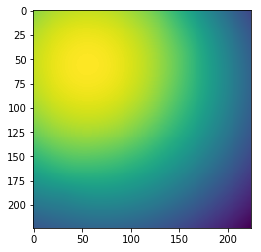

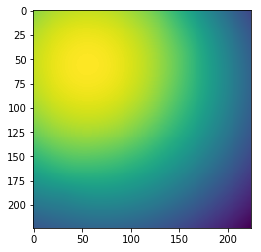

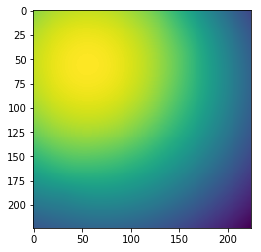

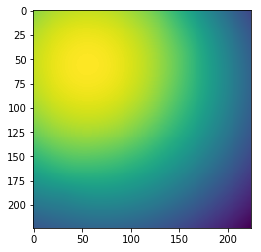

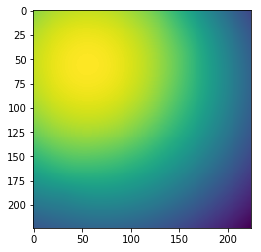

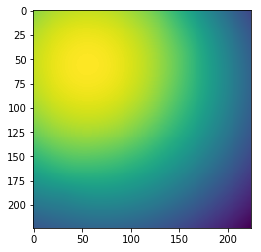

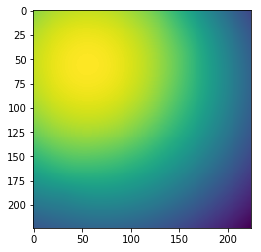

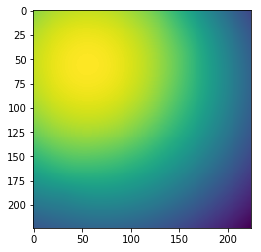

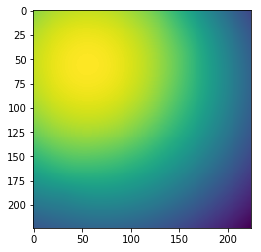

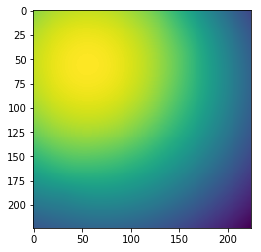

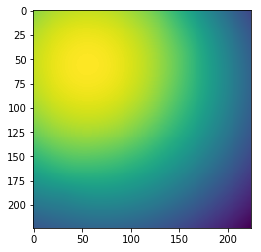

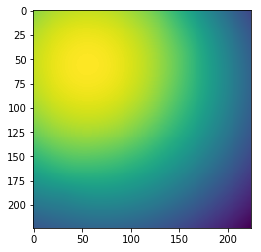

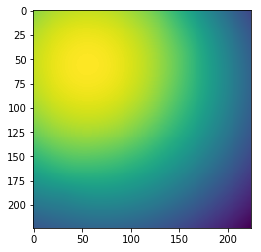

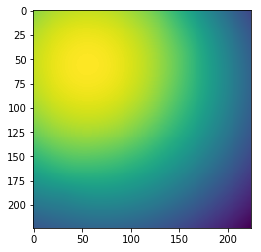

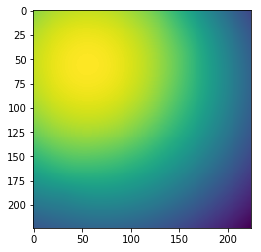

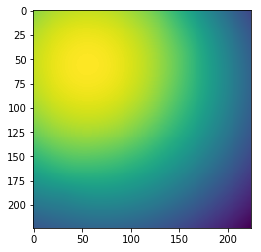

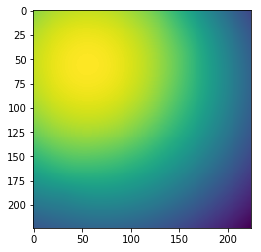

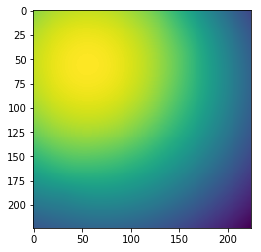

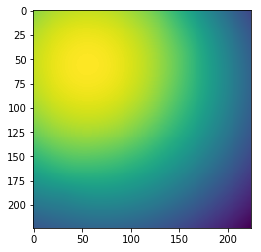

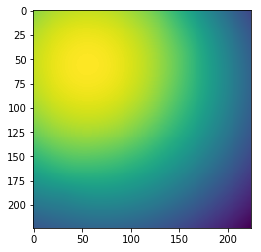

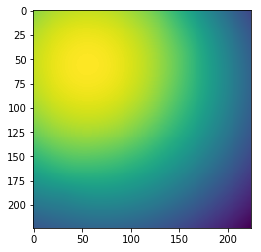

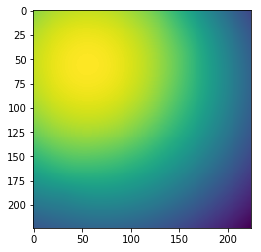

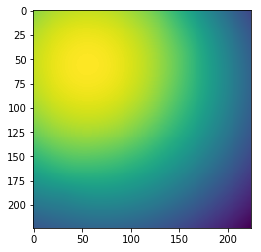

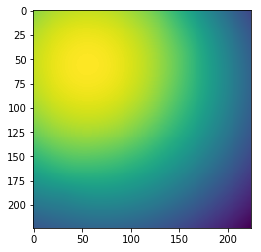

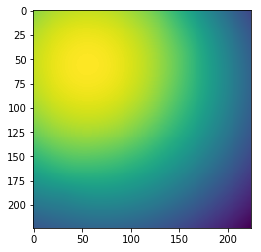

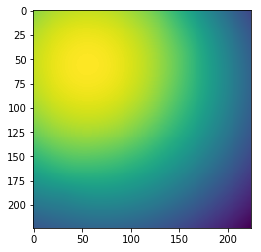

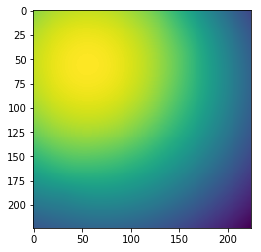

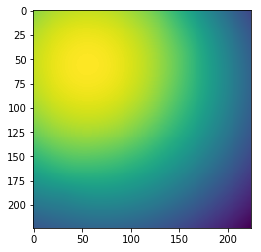

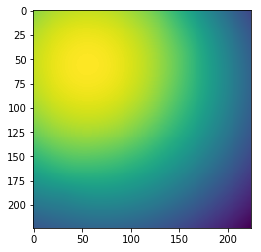

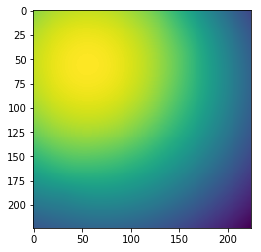

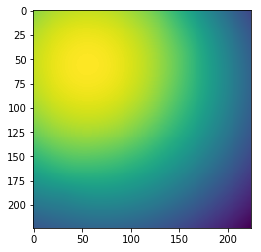

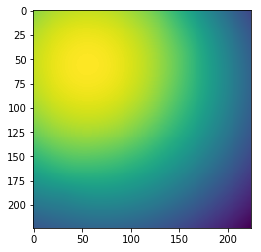

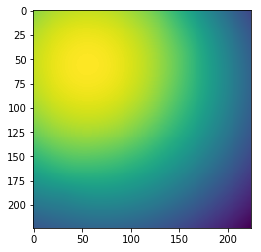

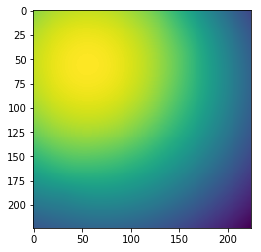

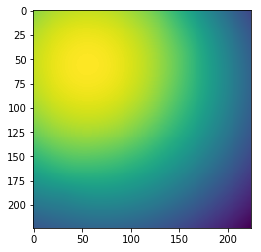

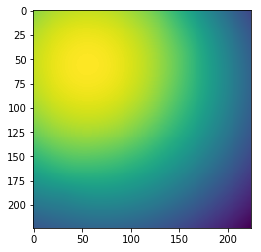

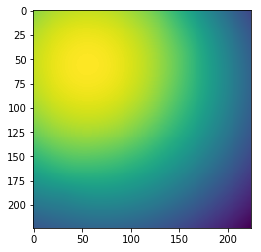

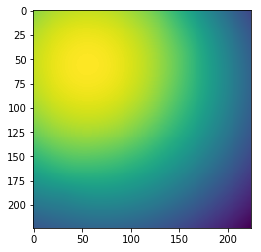

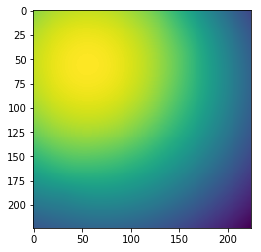

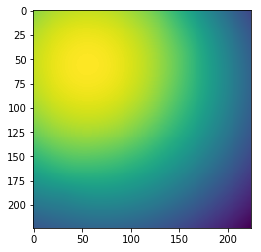

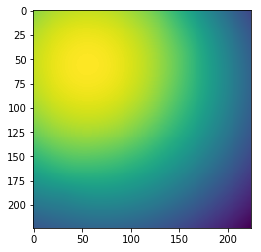

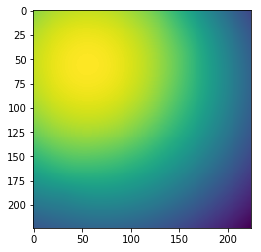

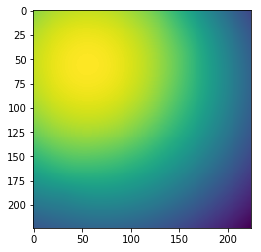

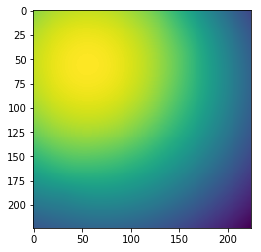

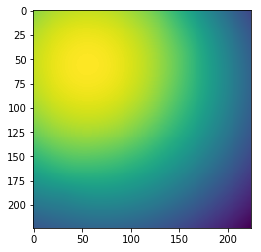

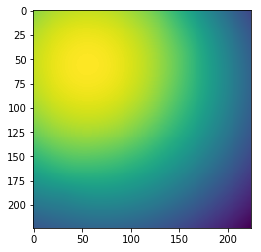

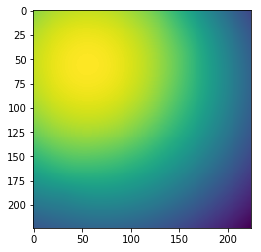

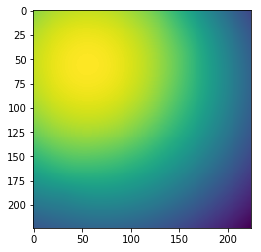

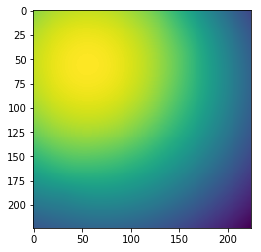

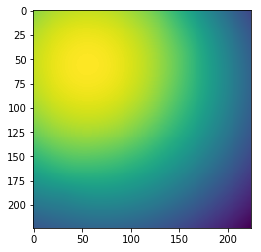

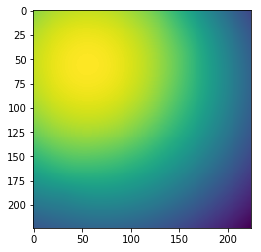

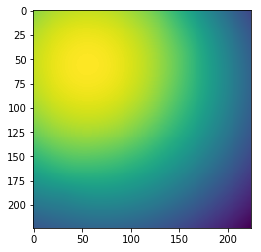

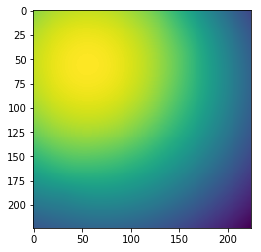

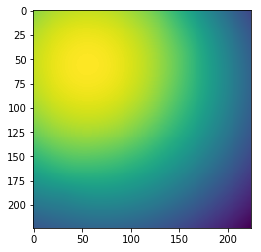

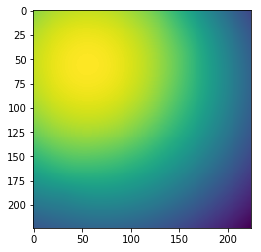

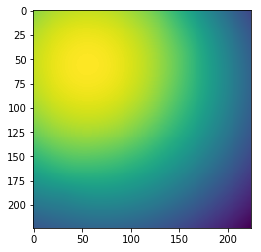

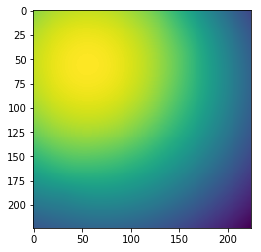

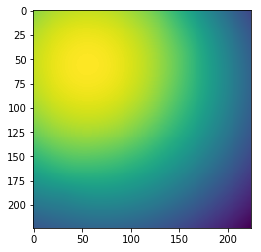

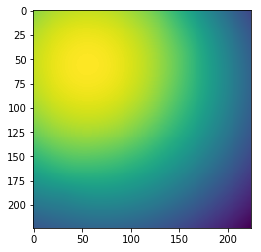

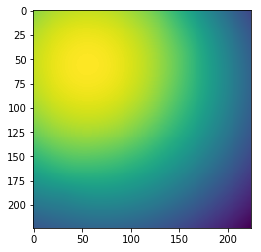

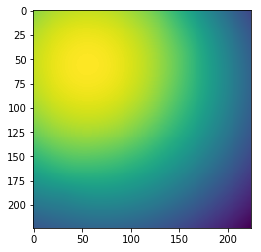

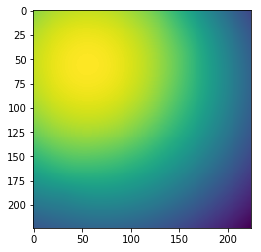

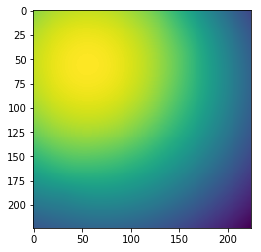

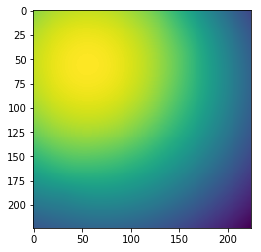

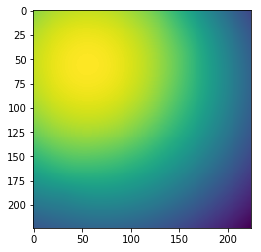

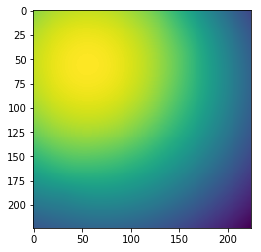

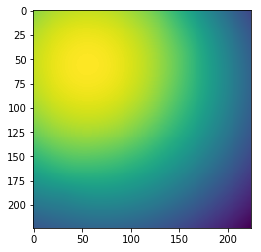

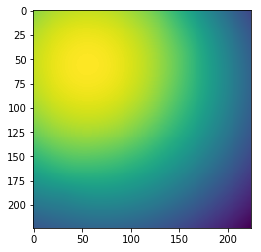

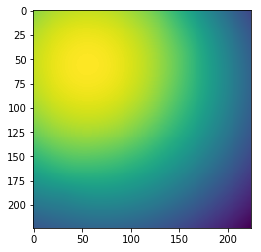

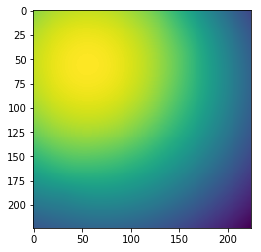

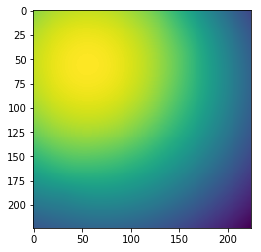

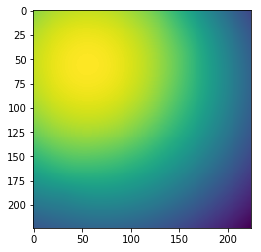

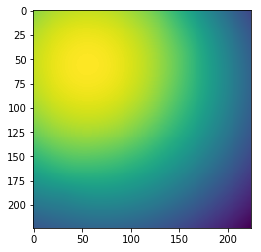

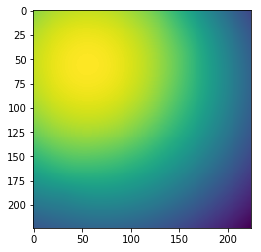

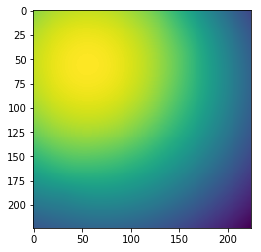

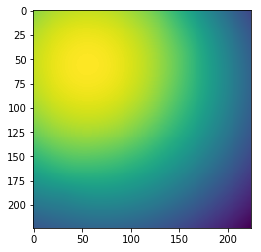

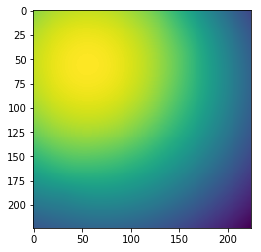

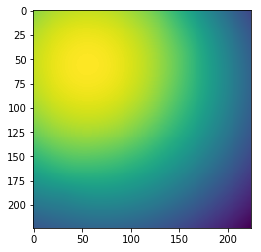

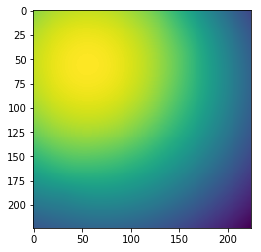

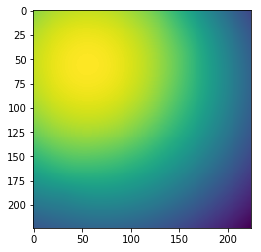

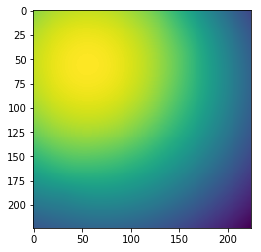

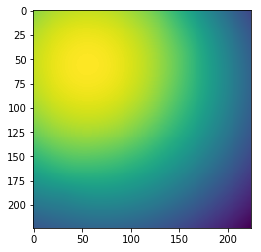

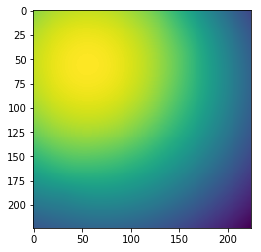

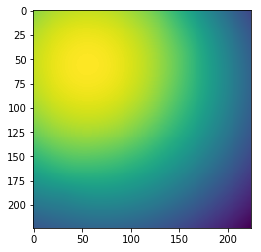

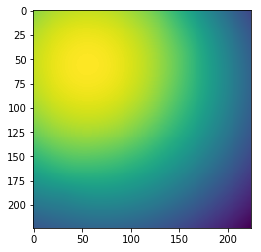

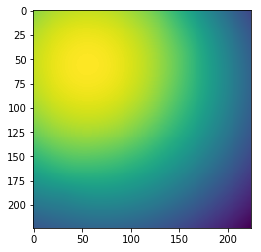

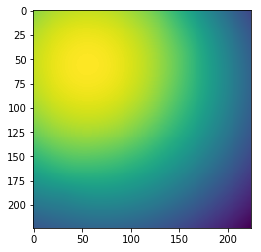

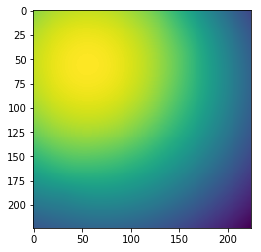

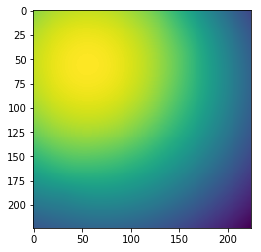

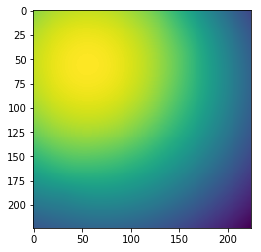

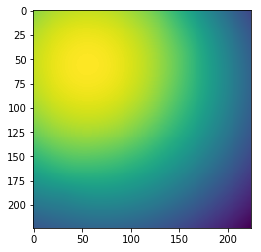

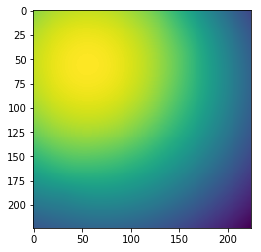

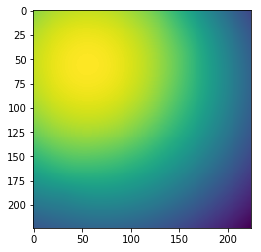

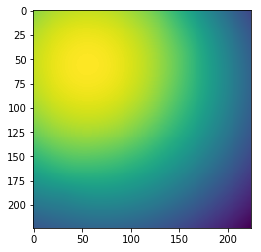

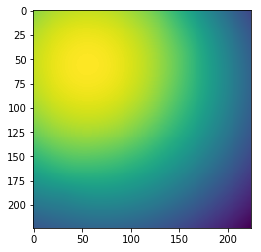

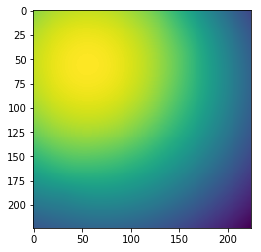

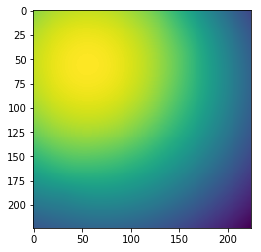

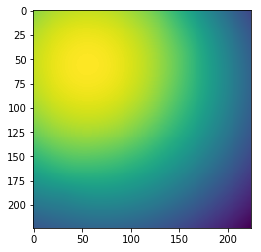

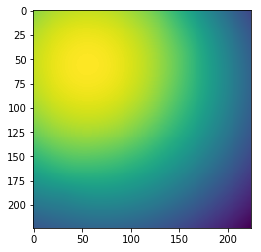

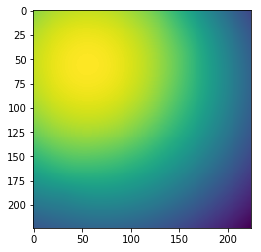

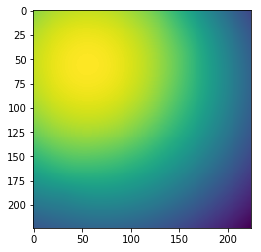

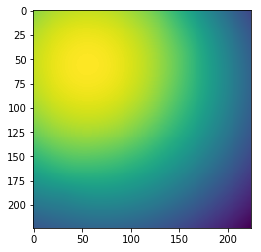

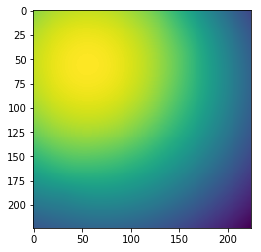

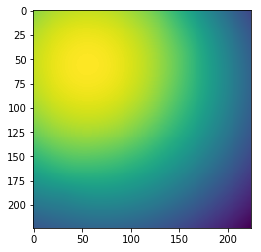

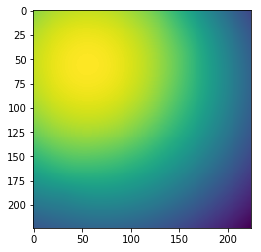

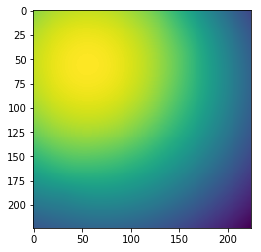

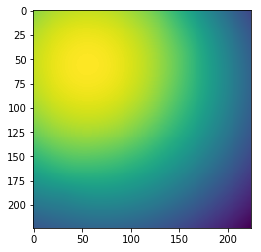

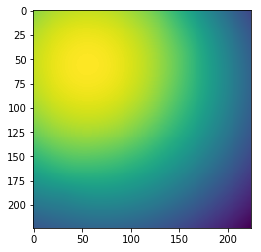

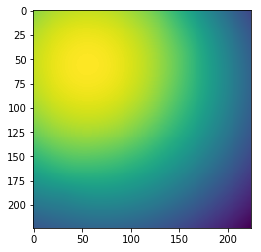

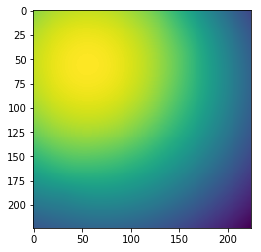

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/s7thakur/.local/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/home/s7thakur/.local/lib/python3.6/site-packages/IPython/core/display.py", line 304, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/home/s7thakur/.local/lib/python3.6/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "</home/s7thakur/.local/lib/python3.6/site-packages/decorator.py:decorator-gen-9>", line 2, in __call__
  File "/home/s7thakur/.local/lib/python3.6/site-packages/IPython/core/formatters.py", line 224, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/home/s7thakur/.local/lib/python3.6/site-packages/IPython/core/formatters.py", line 341, in __call__
    return printer(obj)
  File "/home/s7thakur/.local/lib/python3.6/si

In [ ]:
p1 = 0.5
sal_swage = explain(model, x, 937)

In [149]:
sal_swage

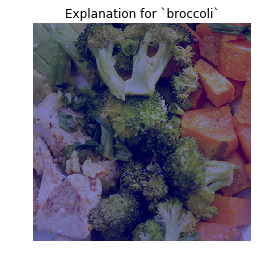

In [70]:

class_idx = 937
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal_swage[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()

In [2]:
import numpy as np
from scipy.interpolate import Rbf

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm

# 2-d tests - setup scattered data
x = np.random.rand(100)*4.0-2.0
y = np.random.rand(100)*4.0-2.0
z = x*np.exp(-x**2-y**2)
ti = np.linspace(-2.0, 2.0, 100)
XI, YI = np.meshgrid(ti, ti)

# use RBF
rbf = Rbf(x, y, z, epsilon=2)
ZI = rbf(XI, YI)

# plot the result
# n = plt.normalize(-2., 2.)
plt.subplot(1, 1, 1)
plt.pcolor(XI, YI, ZI, cmap=cm.jet)
plt.scatter(x, y, 100, z, cmap=cm.jet)
plt.title('RBF interpolation - multiquadrics')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.colorbar()
plt.show
# plt.savefig('rbf2d.png')

In [237]:
masks_swage.shape

(16, 224, 224, 1)

In [26]:
class_idx = 937
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal_rise[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()

NameError: name 'sal_rise' is not defined

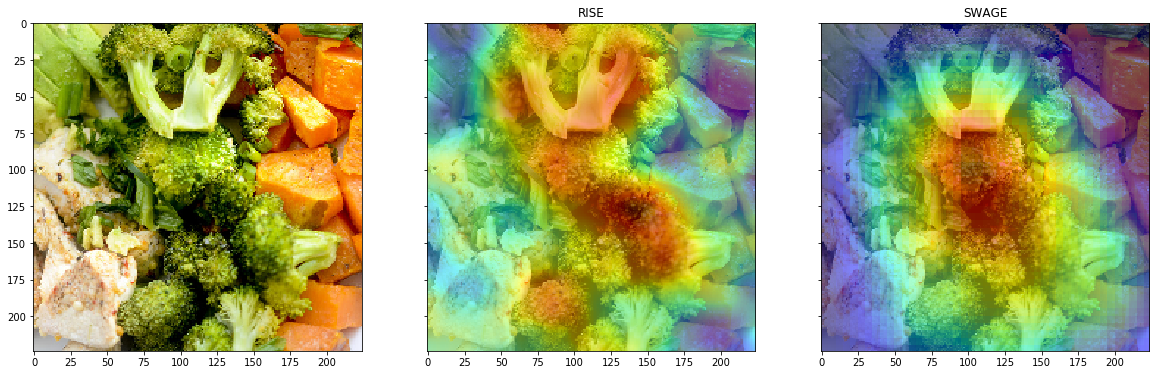

In [208]:
class_idx = 937
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row', figsize=(20,20))

ax1.imshow(img)

ax2.imshow(img)
ax2.imshow(sal_rise[class_idx], cmap='jet', alpha=0.5)
ax2.set_title('RISE')
# 2nd suplot
ax3.imshow(img)
ax3.imshow(sal_swage[class_idx], cmap='jet', alpha=0.5)
ax3.set_title('SWAGE')

plt.savefig('explain-broccoli1.png')

In [76]:
masked = true*masks

masked.shape

(2000, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


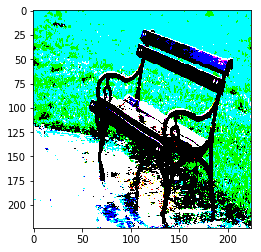

In [49]:
plt.imshow(x.reshape(224,224,3))